Total Return: 170.60
Total Trade Num: 56790
Max Drawdown: 60.53%
Max Single Trade Loss: -22.20
Profit Factor: 168.35
Long Trade Num: 629
Long Win Rate: 68.20%
Short Trade Num: 0
Short Win Rate: 0.00%


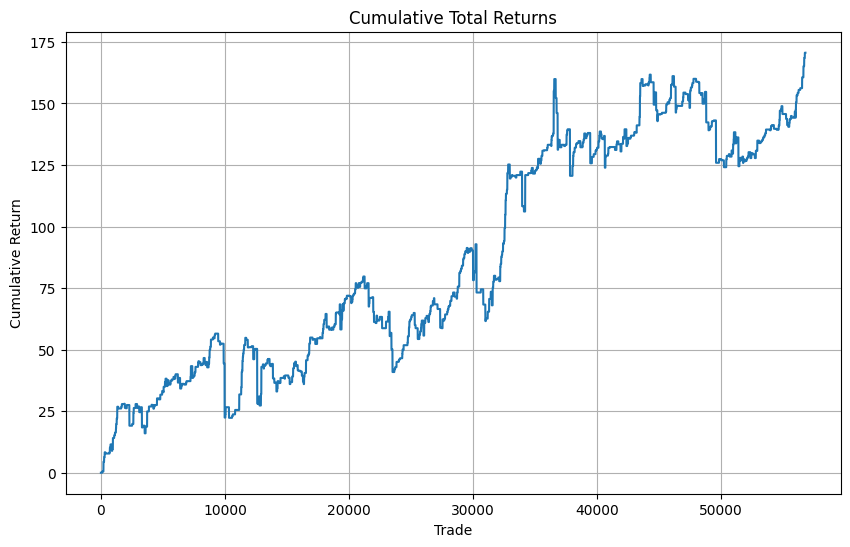

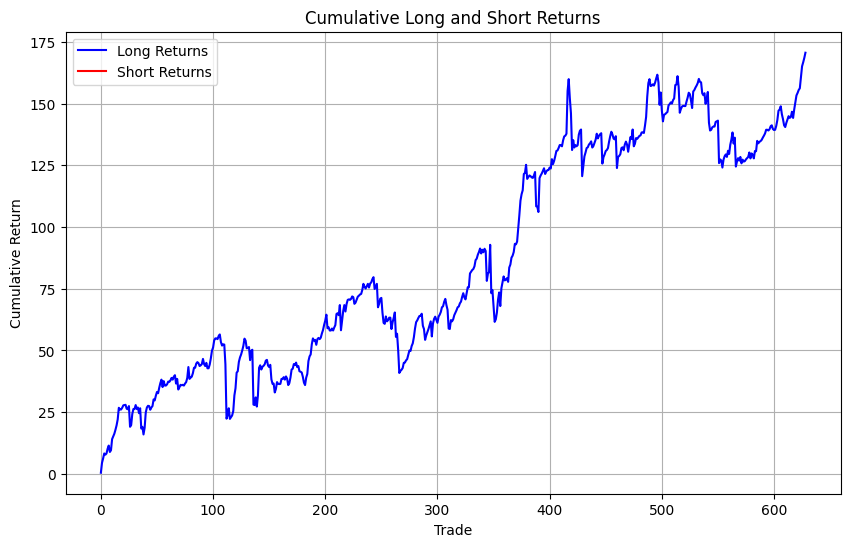

interactive(children=(DatePicker(value=Timestamp('2023-04-03 07:00:00'), description='Start Date', step=1), Da…

Execution time: 0 minutes 44.79 seconds


In [3]:
import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
import matplotlib.pyplot as plt
import pickle
import time
import mplfinance as mpf
from ipywidgets import interact, widgets
import sys
import os

# Add the path to the system path
lib_path = os.path.abspath(os.path.join('lib'))
sys.path.append(lib_path)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def load_data(file_names):
    dfs = []
    for file_name in file_names:
        df = pd.read_csv(file_name, index_col="date")
        dfs.append(df)
    return dfs

def predict(data_row):
    data_row = data_row.drop("target")
    
    # Reshape the data_row into the correct format
    data_row = data_row.values.reshape(1, -1)
    prediction_proba = model.predict(data_row)
    predicted_class = [1 if prob > 0.5 else 0 for prob in prediction_proba]

    return predicted_class[0]

# feature engineering
def feature_engineering(df):
    open = df['open'].values
    high = df['high'].values
    low = df['low'].values
    close = df['close'].values
    # volume = df['volume'].values
    hilo = (high + low) / 2

    rsi = talib.RSI(close, timeperiod=8) # default = 14
    df['RSI'] = rsi
    df['RSI_BB_UPPER'], df['RSI_BB_MIDDLE'], df['RSI_BB_LOWER'] = talib.BBANDS(rsi, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    
    df['RSI_ST'] = talib.RSI(close)/close
    df['RSI_LOG'] = log_transform_feature(talib.RSI(close))
    df['MACD'], _, _ = talib.MACD(close)
    df['MACD_ST'], _, _ = talib.MACD(close)/close
    df['ATR'] = talib.ATR(high, low, close)
    
    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['+DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['-DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    
    df['SMA20'] = talib.SMA(close, timeperiod=20)
    df['SMA50'] = talib.SMA(close, timeperiod=50)
    df['SMA200'] = talib.SMA(close, timeperiod=200)
    
    df['BB_UPPER'], df['BB_MIDDLE'], df['BB_LOWER'] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] = (df['BB_UPPER'] - hilo) / close
    df['BBANDS_middleband'] = (df['BB_MIDDLE'] - hilo) / close
    df['BBANDS_lowerband'] = (df['BB_LOWER'] - hilo) / close

    df['STOCH_K'], df['STOCH_D'] = talib.STOCH(high, low, close)/close
    df['MON'] = talib.MOM(close, timeperiod=5)

    df = df.fillna(method='ffill')

    return df

def log_transform_feature(X):
    X[X <= 0] = np.finfo(float).eps
    return np.log(X)

def create_label(df, lookbehind=1):
    df['target'] = (df['close'] > df['close'].shift(lookbehind)).astype(int)
    df = df.fillna(method='ffill')
    return df

def price_relation(df, short_prefix, long_prefix):
    short_close = df[f'{short_prefix}_close']
    long_support = df[f'{long_prefix}_support']
    long_resistance = df[f'{long_prefix}_resistance']
    df[f'{short_prefix}_close_to_{long_prefix}_support'] = (short_close - long_support) / long_support
    df[f'{short_prefix}_close_to_{long_prefix}_resistance'] = (short_close - long_resistance) / long_resistance
    return df

def summarize_trade_results(trade_results):
    num_trades = len(trade_results['profits'])
    num_wins = sum(1 for x in trade_results['profits'] if x > 0)
    num_losses = num_trades - num_wins

    total_return = sum(trade_results['profits'])

    average_win = sum(x for x in trade_results['profits'] if x > 0) / num_wins if num_wins > 0 else 0
    average_loss = sum(x for x in trade_results['profits'] if x < 0) / num_losses if num_losses > 0 else 0

    profit_factor = -average_win / average_loss if average_loss != 0 else 0

    long_win_rate = sum(1 for x in trade_results['long_profits'] if x > 0) / len(trade_results['long_profits']) if trade_results['long_profits'] else 0
    short_win_rate = sum(1 for x in trade_results['short_profits'] if x > 0) / len(trade_results['short_profits']) if trade_results['short_profits'] else 0

    # Create cumulative return series
    cumulative_returns = np.cumsum(trade_results['profits'])
    cumulative_long_returns = np.cumsum(trade_results['long_profits'])
    cumulative_short_returns = np.cumsum(trade_results['short_profits'])

    # Calculate maximum drawdown using numpy
    cumulative_max = np.maximum.accumulate(cumulative_returns)
    non_zero_max = cumulative_max > 0
    drawdowns = np.full_like(cumulative_returns, fill_value=0)
    drawdowns[non_zero_max] = 1 - cumulative_returns[non_zero_max] / cumulative_max[non_zero_max]
    max_drawdown = np.max(drawdowns)
    maximum_single_trade_loss = min(trade_results['profits']) if trade_results['profits'] else 0

    # Print the statistics
    print(f"Total Return: {total_return:.2f}")
    print(f"Total Trade Num: {len(trade_results['profits'])}")
    print(f"Max Drawdown: {max_drawdown * 100:.2f}%")
    print(f"Max Single Trade Loss: {maximum_single_trade_loss:.2f}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Long Trade Num: {len(trade_results['long_profits'])}")
    print(f"Long Win Rate: {long_win_rate * 100:.2f}%")
    print(f"Short Trade Num: {len(trade_results['short_profits'])}")
    print(f"Short Win Rate: {short_win_rate * 100:.2f}%")

    # Plot the results
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_returns, label='Total Returns')
    plt.title("Cumulative Total Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_long_returns, label='Long Returns', color='blue')
    plt.plot(cumulative_short_returns, label='Short Returns', color='red')
    plt.title("Cumulative Long and Short Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

def calc_trade_fee(price):
    fee_rate = 0.001
    return price * fee_rate

def initPortfolio():
    portfolio = {
        'position': None,  # "long" or "short"
        'entry_price': None,
        'entry_point': 0
    }
    return portfolio

if __name__ == "__main__":
    start_time = time.time() 

    file_names = ["test_combined_data.csv"]
    dfs = load_data(file_names)

    # Assuming you have only one DataFrame in the list
    df = dfs[0]
    df.index = pd.to_datetime(df.index) # ensure that index is datetime
    df = feature_engineering(df)
    df = create_label(df, 15)

    model_path = "model/simple_1m_model.pkl"
    with open(model_path, "rb") as f:
        model = pickle.load(f)

    # Initialize trade_results
    trade_results = {
        'profits': [],
        'long_profits': [],
        'short_profits': [],
    }

    # Initialize portfolio state
    portfolio = initPortfolio()

    # Loop through the data
    for i in range(0, len(df)):
        profit = 0

        # Get the current row of data
        data_row = df.iloc[i]
        prev_row = df.iloc[i-1]

        # Retrieve the RSI and Bollinger Bands from the row
        rsi = data_row['RSI']
        rsi_prev = prev_row['RSI']
        rsi_upper = data_row['RSI_BB_UPPER']
        rsi_lower = data_row['RSI_BB_LOWER']
        bb_upper = data_row['BB_UPPER']
        bb_lower = data_row['BB_LOWER']
        bb_middle = data_row['BB_MIDDLE']

        # Make a prediction with the model
        y_pred = predict(data_row)

        # Exit
        if portfolio['position'] is not None:
            if portfolio['position'] == 'long':
                if data_row['high'] >= bb_upper:

                    profit = data_row['close'] - portfolio['entry_price']
                    trade_results['profits'].append(profit)
                    trade_results['long_profits'].append(profit)
                    portfolio = initPortfolio()
                
                else:
                    trade_results['profits'].append(0)
            elif portfolio['position'] == 'short':
                if data_row['low'] <= bb_lower:
                    
                    profit = portfolio['entry_price'] - data_row['close']
                    trade_results['profits'].append(profit)
                    trade_results['short_profits'].append(profit)
                    portfolio = initPortfolio()

                else:
                    trade_results['profits'].append(0)
            else:
                trade_results['profits'].append(0)
        
        # Short Entry
        # elif rsi_prev > rsi_upper and rsi < rsi_upper:
        #     # if y_pred == 0:
        #         trade_results['profits'].append(0)
        #         portfolio = {
        #             'position': 'short',
        #             'entry_price': data_row['close'],
        #             'entry_point': i
        #         }

        # Long Entry
        elif rsi_prev < rsi_lower and rsi > rsi_lower:
            # if y_pred == 1:
                trade_results['profits'].append(0)
                portfolio = {
                    'position': 'long',
                    'entry_price': data_row['close'],
                    'entry_point': i
                }

        else:
            trade_results['profits'].append(0)

    summarize_trade_results(trade_results)

    # plot ====
    def plot_candlestick(start, end):
        start = pd.to_datetime(start)
        end = pd.to_datetime(end)
        
        plot_df = df.loc[start:end]
        ohlc_df = plot_df[['open', 'high', 'low', 'close']]
        ohlc_df.columns = ['open', 'high', 'low', 'close']
        
        mpf.plot(ohlc_df, type='line', style='yahoo', volume=False, tight_layout=True, warn_too_much_data=7000000)

    start_date = widgets.DatePicker(
        description='Start Date',
        value=pd.to_datetime(df.index.min()),
        disabled=False
    )

    end_date = widgets.DatePicker(
        description='End Date',
        value=pd.to_datetime(df.index.max()),
        disabled=False
    )

    interact(plot_candlestick, start=start_date, end=end_date)
    # plot ====

    elapsed_time = time.time() - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    print(f"Execution time: {int(minutes)} minutes {seconds:.2f} seconds")